# Ratio Analyses and Correcting Functions 


In [1]:
import numpy as np
import pandas as pd
import os
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style='whitegrid')

import itertools as it

from os.path import join as pjoin

%config InteractiveShell.ast_node_interactivity='all'
%config InlineBackend.figure_format = 'svg'

# Helper Functions

In [2]:
def get_series(tdf, column='440'):
    """Returns a specific column as a Pandas Series"""
    
    return tdf[column]


def plot_relationship(tdf, column='440'):

    """Given a wavelength of interest this function displays a
    plot of the sum of the predicted values vs the values at
    that wavelength"""
    
    s1 = get_series(tdf, column)
    sm = get_series(tdf, 'B_p'+column) + get_series(tdf, 'C_p'+column)
    
    sns.regplot(x=s1, y=sm)
    plt.show()
    plt.close()
    
    

def get_96position(tdf, column='440'):
    """Returns the values of wanted column (wavelength) as a DataFrame
    resembling its 96well plate layout. Facilitates comparison"""
    ninsix = pd.DataFrame()
    for l in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
        c = tdf[tdf.index.str.contains(l)][column].values
        ninsix[l] = c
    ninsix = ninsix.transpose()
    ninsix.columns = ninsix.columns+1

    return ninsix.round(6)


def set_B_and_C(tdf, column):
    """This helper function sets the concentraiton values B and
    C on the dataframe for regressiong purposes and so that the 
    plotting function can plot the right values on the x-axis"""
    
    df = tdf.copy()
    
    rows = df['row'].unique()
    cols =  df['col'].unique()
    
    for row in rows:
        #print(row)
        value = df.loc[(df['row']==row) & (df['col']==12), column].iloc[0]
        df.loc[df['row']==row, 'B'] = value

    for col in cols:
        value = df.loc[(df['row']=='H') & (df['col']==col), column].iloc[0]
        df.loc[df['col']==col, 'C'] = value
    
    return df


def plot_pred_vs_known(mdf, column='440', ml_model=False):
    
    """This function takes in the previously calculated prediction values and
    outputs the the predicted vs known values for [chlamy] and [bacter], 
    column refers to the variable wavelength used to construct the regression
    that gave rise to the predicted values"""
    
    df = mdf.copy()

    df = set_B_and_C(df, column)
    
    # figsize
    fs = (8, 10)
    # alpha value for plot markers (see-throughness)
    a = 0.65
    # bacter figure
    fig0 = plt.figure(figsize=fs)
    gs = gridspec.GridSpec(2,1)
    axes = []
    for r in [0,1]:
        for c in [0]:
            axes.append(fig0.add_subplot(gs[r,c]))

    
    # get predicted values from column named
    if ml_model:
        Bp = 'B_pML_'+column
    else:
        Bp = 'B_p'+column
        
    if ml_model:
        Cp = 'C_pML_'+column
    else:
        Cp = 'C_p'+column
        
    # set the scale maximum of the plot to be the maximum value of the maximum
    # of the predicted and known values, which -ever is greater
    smx = max(df[Bp].max(), df['B'].max(), df[Cp].max(), df['C'].max())
    smx = smx+.1*smx
    
    sns.scatterplot(x='B', y=Bp, data=df, hue='row',
                    palette=sns.color_palette("YlOrRd_r", 8),
                    edgecolor='black', alpha=a, ax=axes[0])
    
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles[::-1], labels[:-9:-1], title='[B] gradient')
    axes[0].set_title('Predicted vs. Actual [B]')
    axes[0].set_ylabel('$\hat{[B]}$$_{pred}$')
    axes[0].set_xlabel('$[B]_{known}$')

    axes[0].plot((0,1), 'r--',)
    axes[0].set_xlim(left=-0.02, right=smx) 
    axes[0].set_ylim(bottom=-0.02, top=smx)


    sns.scatterplot(x='B', y=Bp, data=df, hue='col',
                    palette=sns.color_palette("YlGn_r", 12),
                    edgecolor='black', alpha=a, ax=axes[1])

    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles[::-1], labels[:-13:-1], title='[C] gradient',
                   loc=2, prop={'size':9})
    axes[1].set_title('Predicted vs. Actual [B]')
    axes[1].set_ylabel('$\hat{[B]}$$_{pred}$')
    axes[1].set_xlabel('$[B]_{known}$')

    axes[1].plot((0,1), 'r--',)
    axes[1].set_xlim(left=-0.02, right=smx)
    axes[1].set_ylim(bottom=-0.02, top=smx)

    if ml_model:
        fig0.suptitle("[Bacteria] Predictions Using ML Multiple Linear Regression @"+column, y=.95)
    else:
        fig0.suptitle("[Bacteria] Predictions Using Simple Linear Regression Models @"+column, y=.95)
        
    fig0.subplots_adjust(hspace=.3)
    
    #plt.show()
    #plt.close()



    # CHLAMY
    fig1=plt.figure(figsize=fs)
    gs = gridspec.GridSpec(2,1)
    axes = []
    for r in [0,1]:
        for c in [0]:
            axes.append(fig1.add_subplot(gs[r,c]))

        
    # set the scale maximum of the plot to be the maximum value of the maximum
    # of the predicted and known values, which -ever is greater
    smx = max(df[Cp].max(), df['C'].max(), df[Bp].max(), df['B'].max())
    smx = smx+.1*smx
    
    
    
    sns.scatterplot(x='C', y=Cp, data=df, hue='row',
                    palette=sns.color_palette("YlOrRd_r", 8),
                    edgecolor='black', alpha=a,ax=axes[0])


    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles[::-1], labels[:-9:-1], title='[B] gradient')
    axes[0].set_title('Predicted vs. Actual [C]')
    axes[0].set_ylabel('$\hat{[C]_{pred}}$')
    axes[0].set_xlabel('$[C]_{known}$')

    axes[0].plot((0,1), 'r--',)
    axes[0].set_xlim(left=-0.02, right=smx)
    axes[0].set_ylim(bottom=-0.02, top=smx)


    sns.scatterplot(x='C', y=Cp, data=df, hue='col',
                    palette=sns.color_palette("YlGn_r", 12),
                    edgecolor='black', alpha=a, ax=axes[1])

    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles[::-1], labels[:-13:-1], title='[C] gradient',
                  prop={'size':9}, loc=2)
    axes[1].set_title('Predicted vs. Actual [C]')
    axes[1].set_ylabel('$\hat{[C]_{pred}}$')
    axes[1].set_xlabel('$[C]_{known}$')

    axes[1].plot((0,1), 'r--',)
    axes[1].set_xlim(left=-0.02, right=smx)
    axes[1].set_ylim(bottom=-0.02, top=smx)
    
    if ml_model:
        fig1.suptitle("[Chlamy] Predictions Using ML Multiple Linear Regression @"+column, y=.95)
    else:
        fig1.suptitle("[Chlamy] Predictions Using Simple Linear Regression Models @"+column, y=.95)
    
    fig1.subplots_adjust(hspace=.3)

    plt.show()
    plt.close()
    

# Data

## SingStrainRegression @ 560

# Single Strain Calibration Data

In [6]:
path = '../data_o/calibration/single_species_calibration/predicted_fractions'
fname='a680_720_slr_predicted_fractions.csv'
ssdf = pd.read_csv(pjoin(path,fname), index_col=0)

ssdf.head()

# Working Column
wc = '560'
ssdf = set_B_and_C(ssdf, wc)

,row,col,B_lbl,C_lbl,F680,A680,A750,320,325,330,...,B_p780,C_p780,B_p785,C_p785,B_p790,C_p790,B_p795,C_p795,B_p800,C_p800
well,,,,,,,,,,,,,,,,,,,,,
A1,A,1,0.200,0.25,4666.0,0.7210,0.4146,0.8399,0.8359,0.8349,...,0.218229,0.184846,0.217204,0.183421,0.216328,0.182232,0.215366,0.180928,0.214393,0.179772
B1,B,1,0.175,0.25,4832.0,0.7822,0.4155,0.8916,0.8890,0.8907,...,0.177936,0.225882,0.177097,0.224141,0.176378,0.222687,0.175592,0.221093,0.174794,0.219680
C1,C,1,0.150,0.25,4638.0,0.6925,0.3829,0.7923,0.7897,0.7912,...,0.178864,0.190785,0.178022,0.189315,0.177303,0.188087,0.176513,0.186741,0.175713,0.185548
D1,D,1,0.125,0.25,4775.0,0.6981,0.3593,0.7690,0.7657,0.7669,...,0.117760,0.219283,0.117201,0.217592,0.116722,0.216181,0.116199,0.214633,0.115667,0.213262
E1,E,1,0.100,0.25,4936.0,0.6788,0.3414,0.7440,0.7413,0.7438,...,0.105938,0.216913,0.105434,0.215240,0.105002,0.213844,0.104531,0.212313,0.104051,0.210956


In [5]:
# set 'empirical 560_nm values at B_only or C_only wells
tsdf = ssdf.copy()
tsdf = set_B_and_C(tsdf, wc)

In [6]:
# PREDICTED 560 fractions Fractions
pB = get_96position(tsdf, 'B_p'+wc)
pC = get_96position(tsdf, 'C_p'+wc)

# 'KNOWN Concentrations as Measured by 560 at row H and col 12'
B = get_96position(tsdf, 'B')
C = get_96position(tsdf, 'C')

# empirical measurements
e560 = get_96position(tsdf, wc)

cm = [sns.light_palette("brown", as_cmap=True),
      sns.light_palette("green", as_cmap=True), 
      sns.light_palette("purple", as_cmap=True)]

"Predicted Values @ 560 vs. Expcted 'Known' Concentration @ 560"
'pB'
pB.style.background_gradient(cmap=cm[0], axis=None)
'B_known'
B.style.background_gradient(cmap=cm[0], axis=None)


'pC'
pC.style.background_gradient(cmap=cm[1], axis=None)
'C_known'
C.style.background_gradient(cmap=cm[1], axis=None)

# How should these sums behave
'Sum of B&C-only measured wells  @560'
'Note that this is not the same as A560_total = kB560*[B] + kC560*[C]'
'This is a just a helpful first approximation of what to expect'
msm = B+C
msm.style.background_gradient(cmap=cm[0], axis=None)

print("""Compare emperical measurements vs predicted fraction additions
We note that the Beer-Lamber Law holds True. Meaning that discrepancies
Come from the signals of one analyte being gleaned off and attributed
to the other. This is why individual predictions look terrible, but the
sum of the predictions are solid. The next step would be to correct of this 
signal theft""")

'Empirical @ 560'
e560.style.background_gradient(cmap=cm[2], axis=None)

'Predicted pB & pC @ 560 sums'
sm = pB + pC
sm.style.background_gradient(cmap=cm[2], axis=None )


"Predicted Values @ 560 vs. Expcted 'Known' Concentration @ 560"

'pB'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.263933,0.258003,0.284886,0.269634,0.240913,0.261294,0.238888,0.257675,0.265295,0.267012,0.260932,0.264236
B,0.215238,0.257244,0.209931,0.281354,0.229417,0.235889,0.235034,0.228998,0.223752,0.241994,0.229093,0.23007
C,0.216343,0.198283,0.194432,0.190148,0.180323,0.180979,0.192521,0.179043,0.202793,0.182631,0.173259,0.175897
D,0.14248,0.144266,0.149294,0.165422,0.142586,0.138009,0.136906,0.133115,0.143631,0.133616,0.148233,0.145084
E,0.128186,0.118054,0.116569,0.146575,0.125437,0.131549,0.118205,0.108539,0.086665,0.104119,0.102177,0.112294
F,0.079198,0.072143,0.064663,0.064965,0.032373,0.008575,0.032842,0.016327,0.050746,0.047446,0.068854,0.04734
G,0.054413,0.036735,0.013955,0.003369,-0.025404,-0.026222,-0.020019,0.005111,0.019625,0.03398,0.025463,0.017608
H,0.018013,0.000921,0.00052,0.007123,0.035081,0.018954,0.007721,0.014186,0.027991,0.022696,0.002912,0


'B_known'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655,0.2655
B,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347,0.2347
C,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827,0.1827
D,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483,0.1483
E,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201,0.1201
F,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052,0.052
G,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241,0.0241
H,0,0,0,0,0,0,0,0,0,0,0,0


'pC'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.256317,0.227324,0.192777,0.172259,0.197037,0.140165,0.150175,0.088404,0.067517,0.03941,0.014622,0.001666
B,0.313244,0.215841,0.416908,0.1663,0.14987,0.145542,0.107116,0.088477,0.063063,0.030805,0.008801,0.002308
C,0.264566,0.243505,0.205327,0.194998,0.152531,0.141368,0.117843,0.099774,0.068118,0.037204,0.011899,0.003565
D,0.304109,0.262231,0.254753,0.220161,0.162237,0.199862,0.127862,0.124049,0.066208,0.038592,0.00759,0.001207
E,0.300824,0.277021,0.253663,0.177757,0.178232,0.153907,0.134269,0.101167,0.083227,0.036656,0.011271,0.005783
F,0.305042,0.316527,0.307724,0.2544,0.252815,0.217689,0.128793,0.127572,0.069604,0.036574,0.006989,0.00309
G,0.313707,0.337637,0.266433,0.276337,0.205629,0.177649,0.157517,0.108706,0.068043,0.023972,0.005165,0.0039
H,0.330962,0.32069,0.242601,0.225866,0.172812,0.15058,0.122439,0.09048,0.047217,0.018876,0.004247,-0


'C_known'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0
B,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0
C,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0
D,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0
E,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0
F,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0
G,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0
H,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0


'Sum of B&C-only measured wells  @560'

'Note that this is not the same as A560_total = kB560*[B] + kC560*[C]'

'This is a just a helpful first approximation of what to expect'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.6165,0.5879,0.5078,0.5027,0.4762,0.4406,0.4005,0.3745,0.3416,0.3087,0.2754,0.2655
B,0.5857,0.5571,0.477,0.4719,0.4454,0.4098,0.3697,0.3437,0.3108,0.2779,0.2446,0.2347
C,0.5337,0.5051,0.425,0.4199,0.3934,0.3578,0.3177,0.2917,0.2588,0.2259,0.1926,0.1827
D,0.4993,0.4707,0.3906,0.3855,0.359,0.3234,0.2833,0.2573,0.2244,0.1915,0.1582,0.1483
E,0.4711,0.4425,0.3624,0.3573,0.3308,0.2952,0.2551,0.2291,0.1962,0.1633,0.13,0.1201
F,0.403,0.3744,0.2943,0.2892,0.2627,0.2271,0.187,0.161,0.1281,0.0952,0.0619,0.052
G,0.3751,0.3465,0.2664,0.2613,0.2348,0.1992,0.1591,0.1331,0.1002,0.0673,0.034,0.0241
H,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0


Compare emperical measurements vs predicted fraction additions
We note that the Beer-Lamber Law holds True. Meaning that discrepancies
Come from the signals of one analyte being gleaned off and attributed
to the other. This is why individual predictions look terrible, but the
sum of the predictions are solid. The next step would be to correct of this 
signal theft


'Empirical @ 560'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.5276,0.4919,0.4823,0.4442,0.4404,0.4065,0.3979,0.349,0.3337,0.3104,0.279,0.2655
B,0.5417,0.4805,0.6373,0.4551,0.3846,0.385,0.3496,0.3199,0.2892,0.2736,0.2383,0.2347
C,0.4922,0.4518,0.4099,0.3938,0.3415,0.3273,0.3148,0.2807,0.2734,0.2223,0.1865,0.1827
D,0.4563,0.4166,0.4134,0.3938,0.3122,0.3434,0.2685,0.2585,0.2116,0.1748,0.1574,0.1483
E,0.4388,0.4035,0.3781,0.3321,0.3078,0.2919,0.2547,0.215,0.1731,0.1438,0.1157,0.1201
F,0.3897,0.3956,0.3772,0.322,0.2877,0.2315,0.1669,0.149,0.1263,0.0873,0.0774,0.052
G,0.3687,0.3772,0.2814,0.2804,0.1831,0.1556,0.1389,0.1177,0.0917,0.0633,0.0337,0.0241
H,0.351,0.3224,0.2423,0.2372,0.2107,0.1751,0.135,0.109,0.0761,0.0432,0.0099,0


'Predicted pB & pC @ 560 sums'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.52025,0.485327,0.477663,0.441893,0.43795,0.401459,0.389063,0.346079,0.332812,0.306422,0.275554,0.265902
B,0.528482,0.473085,0.626839,0.447654,0.379287,0.381431,0.34215,0.317475,0.286815,0.272799,0.237894,0.232378
C,0.480909,0.441788,0.399759,0.385146,0.332854,0.322347,0.310364,0.278817,0.270911,0.219835,0.185158,0.179462
D,0.446589,0.406497,0.404047,0.385583,0.304823,0.337871,0.264768,0.257164,0.209839,0.172208,0.155823,0.146291
E,0.42901,0.395075,0.370232,0.324332,0.303669,0.285456,0.252474,0.209706,0.169892,0.140775,0.113448,0.118077
F,0.38424,0.38867,0.372387,0.319365,0.285188,0.226264,0.161635,0.143899,0.12035,0.08402,0.075843,0.05043
G,0.36812,0.374372,0.280388,0.279706,0.180225,0.151427,0.137498,0.113817,0.087668,0.057952,0.030628,0.021508
H,0.348975,0.321611,0.243121,0.232989,0.207893,0.169534,0.13016,0.104666,0.075208,0.041572,0.007159,0


# Correcting for Signal Theft
    
    I think this helps determine how the models glean signal from one analyted and adds it to the other (e.g. how the model takes [B] signal and adds it to pC

# Correct C

In [7]:
from sklearn.linear_model import LinearRegression

In [8]:
def quick_scrip():
    
    """Here we're visualizing the predicted values of C (pC) at each well in a column by
    column basis with respect to the known concetration of B. The lines should all be
    flat if the predictions were perfect, but there is a bit of signal addition given by 
    the bacteria. The addition to the signal is dependant on the concentration of B"""
    
    fig, ax = plt.subplots(figsize=(8,5))
    coefs = []
    yints = []
    c_at_cols = [i for i in C.loc['H'].values]
    for i in range(1,13):

        # create a regression object for pC v [B] (B known) and extract coefficients
        regr = LinearRegression()
        k = regr.fit(y=pC[i].values.reshape(-1,1), X=B[12].values.reshape(-1,1))
                    
        coefs.append(k.coef_[0][0])

        sns.regplot(y=pC[i], x=B[12], order=1)
        #sns.regplot(y=pC[i]-pC[i]['H'], x=B[12], order=1)
        

    ax.set_ylabel('pC')
    ax.set_xlabel('B')


    ax.set_ylim(-0.2, .6)
    ax.set_xlim(-0.4, .8)
    ax.legend(c_at_cols, 
              title='C_known @ Col')
    plt.show()
    print('coefs', coefs)
    print()
    print('c_at_cols', c_at_cols)

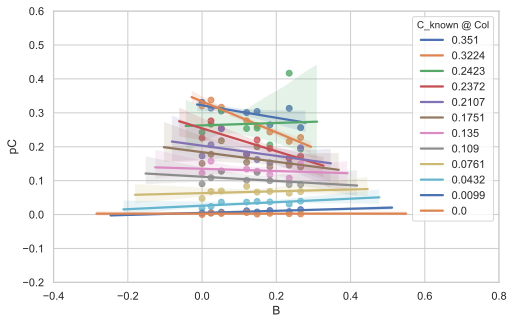

coefs [-0.18318173464707982, -0.455369115922226, 0.035345279700297536, -0.3374664943425418, -0.15007058191395656, -0.14186501366818413, -0.03315481012680046, -0.06222276423276078, 0.02690873401952689, 0.051517836243963645, 0.030340819074733672, -5.257714581259297e-07]

c_at_cols [0.351, 0.3224, 0.2423, 0.2372, 0.2107, 0.1751, 0.135, 0.109, 0.0761, 0.0432, 0.0099, 0.0]


In [9]:
quick_scrip()

coefs [-0.3964178051323839, -0.455369115922226, -0.3964178051323839, -0.3374664943425418, -0.15007058191395656, -0.14186501366818413, -0.03315481012680046, -0.06222276423276078, 0.02690873401952689, 0.051517836243963645, 0.030340819074733672, 0.0]

c_at_cols [0.350999989, 0.32240001100000004, 0.242300011, 0.237199999, 0.210700013, 0.17510000599999995, 0.13499999799999998, 0.109000005, 0.076099999, 0.04319999400000002, 0.009899995999999994, 0.0]


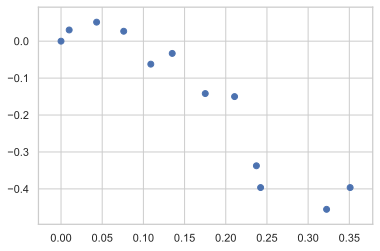

In [10]:
#plot_pred_vs_known(ssdf, wc)
coefs = [-0.18318173464707982, -0.455369115922226, 0.035345279700297536,
         -0.3374664943425418, -0.15007058191395656, -0.14186501366818413,
         -0.03315481012680046, -0.06222276423276078, 0.02690873401952689,
         0.051517836243963645, 0.030340819074733672, 0.0]


# correct for the outlier effect on the regression of column 3 (green line above) well=B3
coefs[2] = np.mean([coefs[1],coefs[3]])

# correct for the apparent outlier effect on the regress of column 1 (blue line aove) well=B1
coefs[0] = np.mean([coefs[1],coefs[2], coefs[3]])
c_at_cols = [0.350999989, 0.32240001100000004, 0.242300011,
             0.237199999, 0.210700013, 0.17510000599999995,
             0.13499999799999998, 0.109000005, 0.076099999,
             0.04319999400000002, 0.009899995999999994, 0.0]


# scatter these two lists and note the type of relationship
plt.scatter(y=coefs, x=c_at_cols)

print('coefs', coefs)
print()
print('c_at_cols', c_at_cols)

Text(0.5, 0, 'C')

Text(0, 0.5, 'correcting_k')

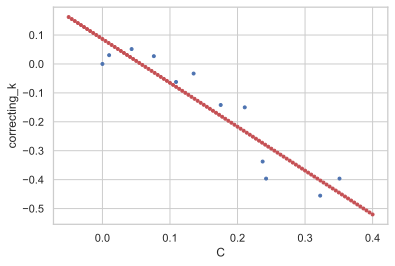

In [11]:
# the coefficients have a dependency on the concentration of chlamy which we can
# exploit to correct for the values of 
k_fit = np.polyfit(x=c_at_cols, y=coefs, deg=1)


k_ptor = np.poly1d(k_fit)

xs = np.linspace(-0.05, .4, 100)
plt.plot(c_at_cols, coefs, 'b.', xs, k_ptor(xs), 'r.')

plt.xlabel('C')
plt.ylabel('correcting_k')

In [12]:
def  corr_func_Css(pB, pC):
    
    # obtained from the empirical data itself, regression coefficients of each
    # column's pC vs. B_known @ [C]=0 (i.e B_only well) (96-well format)
    coefs = [-0.18317955932879285, -0.4553677338194911, 0.035347121040190894,
             -0.33746759907772506, -0.15007213460051003, -0.14186632583482842,
             -0.03315464322646974, -0.062221759683960196, 0.02690820807588553,
             0.05151834743363849, 0.03034145478018707, 0.0]


    # correct for the outlier effect on the regression of column 3 (green line above) well=B3
    coefs[2] = np.mean([coefs[1],coefs[3]])

    # correct for the apparent outlier effect on the regress of column 1 (blue line aove) well=B1
    coefs[0] = np.mean([coefs[1],coefs[2], coefs[3]])
    c_at_cols = [0.350999989, 0.32240001100000004, 0.242300011,
                 0.237199999, 0.210700013, 0.17510000599999995,
                 0.13499999799999998, 0.109000005, 0.076099999,
                 0.04319999400000002, 0.009899995999999994, 0.0]

    
    # this fits the coeficients from each column against C_known... this is to say that
    # every amount of chlamy adds a distinct amount of signal to the prediction of B 
    # accross of a gradient of B, thus we regress to find this coefficient and apply it
    # to correct the signal
    k_fit = np.polyfit(x=c_at_cols, y=coefs, deg=1)
    
    # we use this information to create a
    k_ptor = np.poly1d(k_fit)
    # k_ptor(pC)
    # use the predicted k for the particular value of C at hand, and use it to predict
    # the correction value that will be added/subtracted to C
   
    # probably only works for up to C < 0.25
    
    cv_ptor = np.poly1d(np.array([k_ptor(pC), 0]))
    #print(cv_ptor)
    return cv_ptor(pB)

In [13]:
#plot_pred_vs_known(ssdf, column=wc, ml_model=False)
#plot_pred_vs_known(ssdf, column=wc, ml_model=False)

# Correct B

In [14]:
def quick_scrip():
    
    """Here we're visualizing the predicted values of B (pB) at each well in a row by
    row basis with respect to the known concetration of C. The lines should all be
    flat if the predictions were perfect, but there is a bit of signal addition given by 
    the bacteria. The addition to the signal is dependant on the concentration of B"""
    
    fig, ax = plt.subplots(figsize=(8,5))
    coefs = []
    b_max = []
    b_at_cols = []
    for i in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
        
        b_at_cols.append(B.loc[i][12])
        # append max value of each column
        b_max.append(max(pB.loc[i]))
        # create a regression plot for pB v [C] (C known)
        sns.regplot(y=pB.loc[i], x=C.loc['H'], order=2, truncate=False)
        # check for any patterns --- none exist, but we do see the same
        # effecft of chalmy adding signal to B when [B] < 0.05
        
        # average these regresssion coefficient to a global one
        # and use it as a correction factor for pB
        regr = LinearRegression()
        k = regr.fit(y=pB.loc[i].values.reshape(-1,1), X=C.loc['H'].values.reshape(-1,1))
                    
        coefs.append(k.coef_[0][0])

    ax.set_ylabel('pB')
    ax.set_xlabel('C')


    ax.set_ylim(-0.2, .4)
    ax.set_xlim(-0.3, .8)
    ax.legend(b_at_cols, 
              title='B_known @ Row')
    plt.show()
    print('coefs', coefs)
    print('b_known_at_cols, b_max_at_col', [i for i in zip(b_at_cols, b_max)])

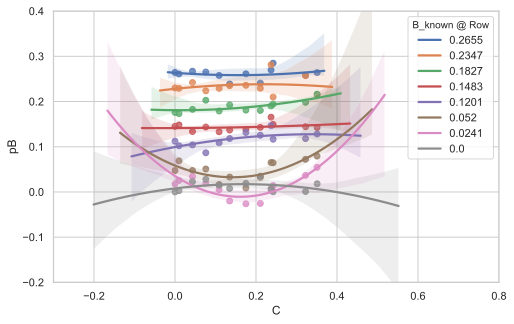

coefs [0.00561516591896593, 0.02120591643777317, 0.07425590485923488, 0.018907692016964742, 0.08395213779805138, 0.06637152011656552, 0.02766946353780928, -2.0941589368631463e-08]
b_known_at_cols, b_max_at_col [(0.2655, 0.284886), (0.2347, 0.281354), (0.1827, 0.216343), (0.1483, 0.165422), (0.1201, 0.146575), (0.052, 0.079198), (0.0241, 0.054413), (0.0, 0.035081)]


1     0.018013
2     0.000921
3     0.000520
4     0.007123
5     0.035081
6     0.018954
7     0.007721
8     0.014186
9     0.027991
10    0.022696
11    0.002912
12    0.000000
Name: H, dtype: float64

1     0.079198
2     0.072143
3     0.064663
4     0.064965
5     0.032373
6     0.008575
7     0.032842
8     0.016327
9     0.050746
10    0.047446
11    0.068854
12    0.047340
Name: F, dtype: float64

In [15]:
quick_scrip()
pB.loc['H']
pB.loc['F']
#pB.loc['B'][1]

In [16]:
# rather than a parabolic dependency in the syncom version there is a linear one just like in the 
# pC v B graphs above, except this one is steadier than the adaptive version made for that one
coefs = np.array([0.00561516591896593, 0.02120591643777317, 0.07425590485923488, 0.018907692016964742,
         0.08395213779805138, 0.06637152011656552, 0.02766946353780928]).mean()

coefs

0.04256825724076642

    Unfortunately there isn't any coherence to the these regression which we can exploit in an adaptive manner. However, we can correct for the effects at very low concentrations of bacteria by using the regression at [B]=0, since we know that at the very least when there is 'No' bacteria present we can remove the addition

In [17]:
y= pB.loc['H'] # pB at 96-well plate row where there should be no bacteria present
x= C.loc['H']  # [C] of C_only wells

# fit a 2nd degree polynomial line to these data
pBfit = np.polyfit(x,y, deg=2)

# the y-intercept should theoretically be zero
pBfit[2] = 0.0

# this is a function that takes in predicted C (pC) values and returns a corretion amount
# however we should write a clause that its only applied to pC <= 0.05
pBtor = np.poly1d(pBfit)

In [18]:
y.values
x.values
pBtor

array([0.018013, 0.000921, 0.00052 , 0.007123, 0.035081, 0.018954,
       0.007721, 0.014186, 0.027991, 0.022696, 0.002912, 0.      ])

array([0.351 , 0.3224, 0.2423, 0.2372, 0.2107, 0.1751, 0.135 , 0.109 ,
       0.0761, 0.0432, 0.0099, 0.    ])

poly1d([-0.32847909,  0.11099588,  0.        ])

In [19]:
y= pB.loc['F'] # pB at 96-well plate row where there should be no bacteria present
x= C.loc['H']  # [C] of C_only wells

In [20]:
x.values
y.values

array([0.351 , 0.3224, 0.2423, 0.2372, 0.2107, 0.1751, 0.135 , 0.109 ,
       0.0761, 0.0432, 0.0099, 0.    ])

array([0.079198, 0.072143, 0.064663, 0.064965, 0.032373, 0.008575,
       0.032842, 0.016327, 0.050746, 0.047446, 0.068854, 0.04734 ])

In [21]:
def  corr_func_Bss(pB, pC):
    
    # pB at 96-well plate row where there should be no bacteria present
    y= [0.018013, 0.000921, 0.00052 , 0.007123, 0.035081, 0.018954,
       0.007721, 0.014186, 0.027991, 0.022696, 0.002912, 0.0] 
    
    # [C] of C_only wells
    x= [0.351 , 0.3224, 0.2423, 0.2372, 0.2107, 0.1751, 0.135 , 0.109 ,
       0.0761, 0.0432, 0.0099, 0.0] 
    
#
    
    # this fits a 2nd degree polynomial line to these data, ... this is to say that
    # every amount of chlamy adds a distinct amount of signal to the prediction of B 
    pBfit = np.polyfit(x,y, deg=2)

    # the y-intercept should theoretically be zero
    pBfit[2] = 0.0
    

    # this is a function that takes in predicted C (pC) values and returns a corretion amount
    # however we should write a clause that its only applied to pC <= 0.05
    pBtor = np.poly1d(pBfit)
    
    
    if pB < 0.1:
        return pBtor(pC)
    else:
        return 0.0
    

In [22]:
def  corr_func_Bss2(pB, pC):
    
    # linear regression coefficients of pB vC 
    Ks= coefs = np.array([0.02120591643777317, 0.018907692016964742, 0.02766946353780928]).mean()
    
    

    # this is a function that takes in predicted C (pC) values and returns a correction amount
    # however we should write a clause that its only applied to pC <= 0.05
    pBtor = np.poly1d(Ks)
    
    if pB > 0.15:
        return 0.0
    else:
        return pBtor(pC)

In [23]:
#tsdf = ssdf.copy()
tsdf = ssdf.copy()

tsdf['Btmp_'+wc] = tsdf['B_p'+wc].copy()
tsdf['Ctmp_'+wc] = tsdf['C_p'+wc].copy()

# always ensure to use the copy of the uncorrected values, because once you correct a column
# the next correction will use the corrected values (wouldn't it be better to use those though?)
tsdf['cf'] =  tsdf.apply(lambda x: corr_func_Css(x['Btmp_'+wc], x['Ctmp_'+wc]), axis=1)

# CORRECT pC
tsdf['C_p'+wc] = tsdf['Ctmp_'+wc] - tsdf['cf']
# in this case it does not make sense to reattribute gleaned signal to B
#tsdf['B_'+wc] = tsdf['Btmp_'+wc] - tsdf['cf']


# CORRECT pB
# use the uncorrected values to correct these 
#tsdf['cf2'] =  tsdf.apply(lambda x: corr_func_Bss(x['Btmp_'+wc], x['Ctmp_'+wc]), axis=1)

# uses corrected C to correct for B
tsdf['cf2'] =  tsdf.apply(lambda x: corr_func_Bss(x['Btmp_'+wc], x['Ctmp_'+wc]), axis=1)

tsdf['B_p'+wc] = tsdf['Btmp_'+wc] + tsdf['cf2']

tsdf[['Btmp_'+wc, 'cf2', 'B_p'+wc, 'Ctmp_'+wc,'C', 'cf' ,'C_p'+wc]].sample(n=10).sort_values(by='well')


,Btmp_560,cf2,B_p560,Ctmp_560,C,cf,C_p560
well,,,,,,,
B11,0.229093,0.000000,0.229093,0.008801,0.0099,0.016721,-0.007920
C4,0.190148,0.000000,0.190148,0.194998,0.2372,-0.039829,0.234827
E4,0.146575,0.000000,0.146575,0.177757,0.2372,-0.026869,0.204625
F7,0.032842,0.008847,0.041689,0.128793,0.1350,-0.003581,0.132374
F8,0.016327,0.008814,0.025141,0.127572,0.1090,-0.001750,0.129322
G1,0.054413,0.002494,0.056907,0.313707,0.3510,-0.021196,0.334903
G12,0.017608,0.000428,0.018035,0.003900,0.0000,0.001416,0.002484
G8,0.005111,0.008184,0.013295,0.108706,0.1090,-0.000402,0.109107
H5,0.035081,0.009372,0.044452,0.172812,0.2107,-0.006168,0.178980


'original'

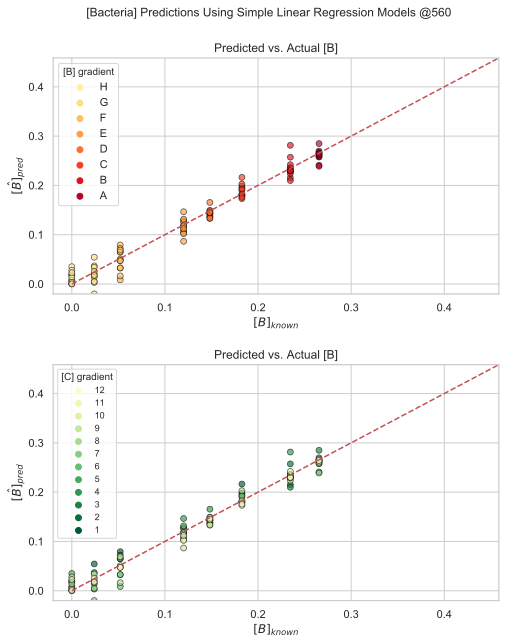

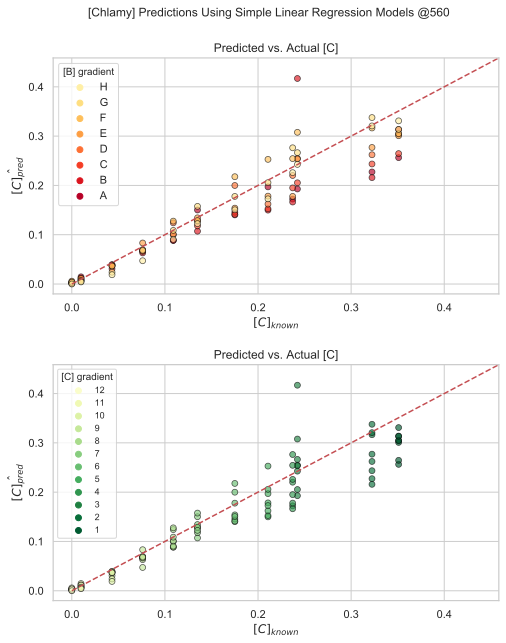

'corrected'

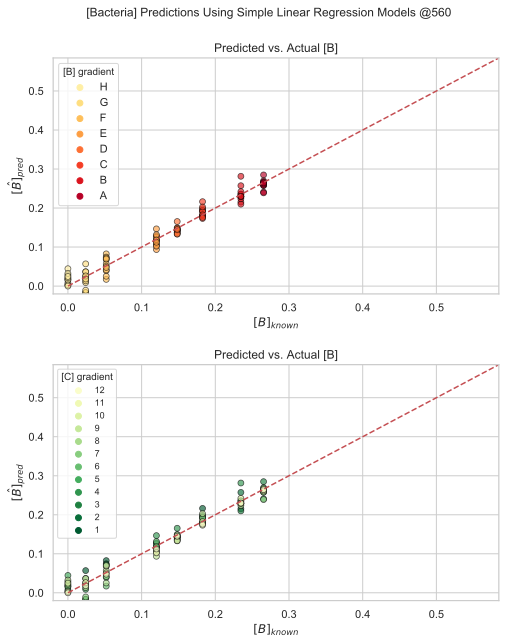

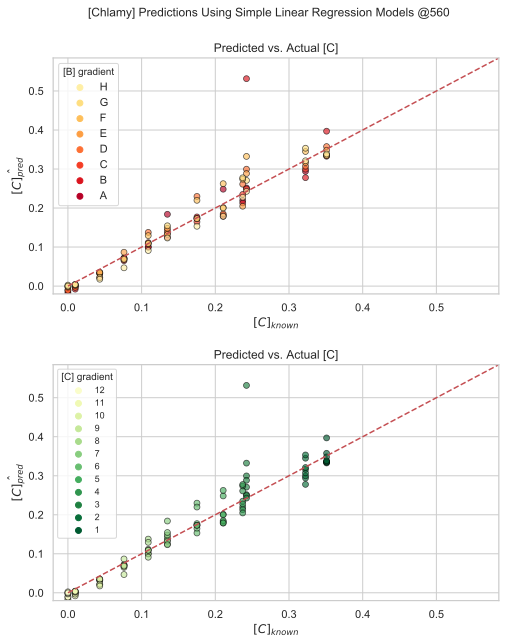

In [24]:
'original'
plot_pred_vs_known(ssdf, column=wc, ml_model=False)

'corrected'
plot_pred_vs_known(tsdf, column=wc, ml_model=False)

# SynCom Calibration Data

In [3]:
path = '../data_o/calibration/community_calibration/predicted_fractions'
fname='a680_a720_pred_fractions.csv'
scdf = pd.read_csv(pjoin(path,fname), index_col=0)

scdf.head()

wc = '560'
# Working Wavelength
wd = wc

scdf = set_B_and_C(scdf, wc)

,row,col,B_lbl,C_lbl,A600,A600_sdv,A680,A680_sdv,A720,A720_sdv,...,B_p710,C_p710,B_p720,C_p720,B_p730,C_p730,B_p740,C_p740,B_p750,C_p750
well,,,,,,,,,,,,,,,,,,,,,
A1,A,1,0.4,0.50,1.0938,0.0618,1.4928,0.0686,0.8732,0.0660,...,0.255450,0.656874,0.251179,0.619558,0.246193,0.596086,0.242318,0.583480,0.237911,0.571970
A2,A,2,0.4,0.46,1.0292,0.0746,1.3929,0.0742,0.8300,0.0714,...,0.270676,0.593367,0.266130,0.559659,0.260821,0.538457,0.256701,0.527069,0.252017,0.516673
A3,A,3,0.4,0.42,0.9685,0.0768,1.2995,0.0818,0.7890,0.0758,...,0.283615,0.534776,0.278836,0.504397,0.273252,0.485288,0.268921,0.475026,0.264001,0.465656
A4,A,4,0.4,0.38,0.9106,0.0732,1.2021,0.0791,0.7450,0.0742,...,0.294469,0.475272,0.289491,0.448274,0.283674,0.431291,0.279167,0.422171,0.274047,0.413844
A5,A,5,0.4,0.34,0.8852,0.0785,1.1458,0.0879,0.7252,0.0804,...,0.312694,0.433649,0.307394,0.409016,0.301199,0.393521,0.296403,0.385199,0.290956,0.377603


In [4]:
# set 'empirical 560_nm values at B_only or C_only wells
tcdf = scdf.copy()
tcdf = set_B_and_C(tcdf, wc)

In [7]:
# PREDICTED 560 fractions Fractions
pB = get_96position(tcdf, 'B_p'+wc).round(4)
pC = get_96position(tcdf, 'C_p'+wc).round(4)

# 'KNOWN Concentrations as Measured by 560 at row H and col 12'
B = get_96position(tcdf, 'B').round(4)
C = get_96position(tcdf, 'C').round(4)

# empirical measurements
e560 = get_96position(tcdf, wc)

cm = [sns.light_palette("brown", as_cmap=True),
      sns.light_palette("green", as_cmap=True), 
      sns.light_palette("purple", as_cmap=True)]

"Predicted Values @ 560 vs. Expcted 'Known' Concentration @ 560"
'pB'
pB.style.background_gradient(cmap=cm[0], axis=None)
'B_known'
B.style.background_gradient(cmap=cm[0], axis=None)


'pC'
pC.style.background_gradient(cmap=cm[1], axis=None)
'C_known'
C.style.background_gradient(cmap=cm[1], axis=None)

# How should these sums behave
'Sum of B&C-only measured wells  @560'
'Note that this is not the same as A560_total = kB560*[B] + kC560*[C]'
'This is a just a helpful first approximation of what to expect'
msm = B+C
msm.style.background_gradient(cmap=cm[0], axis=None)

print("""Compare emperical measurements vs predicted fraction additions
We note that the Beer-Lamber Law holds True. Meaning that discrepancies
Come from the signals of one analyte being gleaned off and attributed
to the other. This is why individual predictions look terrible, but the
sum of the predictions are solid. The next step would be to correct of this 
signal theft""")

'Empirical @ 560'
e560.style.background_gradient(cmap=cm[2], axis=None)

'Predicted pB & pC @ 560 sums'
sm = pB + pC
sm.style.background_gradient(cmap=cm[2], axis=None )


"Predicted Values @ 560 vs. Expcted 'Known' Concentration @ 560"

'pB'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.3412,0.3615,0.3787,0.3931,0.4174,0.4379,0.4407,0.4535,0.4753,0.4815,0.479,0.484
B,0.2905,0.3188,0.3376,0.3551,0.3675,0.3866,0.4042,0.4129,0.4212,0.4172,0.409,0.4049
C,0.2584,0.291,0.3383,0.3502,0.3544,0.3835,0.4032,0.431,0.4218,0.4233,0.4164,0.3892
D,0.2511,0.2576,0.2891,0.3013,0.3229,0.3409,0.3599,0.3462,0.3467,0.3309,0.3202,0.2901
E,0.1824,0.2154,0.2337,0.2521,0.2682,0.2828,0.2882,0.2937,0.3,0.2929,0.2913,0.2582
F,0.136,0.1657,0.185,0.196,0.2199,0.2338,0.2303,0.2434,0.2487,0.2456,0.234,0.2228
G,0.1005,0.1304,0.1439,0.157,0.1609,0.1758,0.1785,0.185,0.1924,0.1833,0.1739,0.1518
H,0.0057,0.0433,0.0521,0.05,0.0568,0.0716,0.0895,0.0654,0.0765,0.0659,0.0445,-0


'B_known'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.478,0.478,0.478,0.478,0.478,0.478,0.478,0.478,0.478,0.478,0.478,0.478
B,0.3868,0.3868,0.3868,0.3868,0.3868,0.3868,0.3868,0.3868,0.3868,0.3868,0.3868,0.3868
C,0.3888,0.3888,0.3888,0.3888,0.3888,0.3888,0.3888,0.3888,0.3888,0.3888,0.3888,0.3888
D,0.3008,0.3008,0.3008,0.3008,0.3008,0.3008,0.3008,0.3008,0.3008,0.3008,0.3008,0.3008
E,0.2673,0.2673,0.2673,0.2673,0.2673,0.2673,0.2673,0.2673,0.2673,0.2673,0.2673,0.2673
F,0.2041,0.2041,0.2041,0.2041,0.2041,0.2041,0.2041,0.2041,0.2041,0.2041,0.2041,0.2041
G,0.1378,0.1378,0.1378,0.1378,0.1378,0.1378,0.1378,0.1378,0.1378,0.1378,0.1378,0.1378
H,0,0,0,0,0,0,0,0,0,0,0,0


'pC'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.7372,0.666,0.6002,0.5334,0.4867,0.4297,0.371,0.309,0.2458,0.1895,0.1236,-0.0037
B,0.7274,0.6562,0.5939,0.5436,0.4819,0.4285,0.3671,0.3076,0.2381,0.1836,0.1223,-0.0027
C,0.709,0.6427,0.5967,0.5525,0.491,0.4352,0.3606,0.3031,0.2381,0.1875,0.1253,0.0007
D,0.7088,0.6343,0.5842,0.5377,0.4869,0.4293,0.3658,0.3013,0.2373,0.1847,0.1219,0.0029
E,0.7042,0.6327,0.5798,0.5324,0.4803,0.4295,0.3674,0.3052,0.2368,0.1857,0.1231,0.0002
F,0.7128,0.637,0.5749,0.5322,0.4781,0.4178,0.3582,0.307,0.2335,0.1806,0.1247,-0.0038
G,0.7072,0.6229,0.5765,0.5296,0.4775,0.4171,0.3566,0.3017,0.2418,0.1783,0.1173,-0.005
H,0.7037,0.6169,0.5733,0.5364,0.4855,0.419,0.3522,0.2919,0.2263,0.1718,0.112,0


'C_known'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.6999,0.6313,0.5892,0.563,0.5084,0.4475,0.3913,0.3235,0.2445,0.1935,0.1298,0
B,0.6999,0.6313,0.5892,0.563,0.5084,0.4475,0.3913,0.3235,0.2445,0.1935,0.1298,0
C,0.6999,0.6313,0.5892,0.563,0.5084,0.4475,0.3913,0.3235,0.2445,0.1935,0.1298,0
D,0.6999,0.6313,0.5892,0.563,0.5084,0.4475,0.3913,0.3235,0.2445,0.1935,0.1298,0
E,0.6999,0.6313,0.5892,0.563,0.5084,0.4475,0.3913,0.3235,0.2445,0.1935,0.1298,0
F,0.6999,0.6313,0.5892,0.563,0.5084,0.4475,0.3913,0.3235,0.2445,0.1935,0.1298,0
G,0.6999,0.6313,0.5892,0.563,0.5084,0.4475,0.3913,0.3235,0.2445,0.1935,0.1298,0
H,0.6999,0.6313,0.5892,0.563,0.5084,0.4475,0.3913,0.3235,0.2445,0.1935,0.1298,0


'Sum of B&C-only measured wells  @560'

'Note that this is not the same as A560_total = kB560*[B] + kC560*[C]'

'This is a just a helpful first approximation of what to expect'

,1,2,3,4,5,6,7,8,9,10,11,12
A,1.1779,1.1093,1.0672,1.041,0.9864,0.9255,0.8693,0.8015,0.7225,0.6715,0.6078,0.478
B,1.0867,1.0181,0.976,0.9498,0.8952,0.8343,0.7781,0.7103,0.6313,0.5803,0.5166,0.3868
C,1.0887,1.0201,0.978,0.9518,0.8972,0.8363,0.7801,0.7123,0.6333,0.5823,0.5186,0.3888
D,1.0007,0.9321,0.89,0.8638,0.8092,0.7483,0.6921,0.6243,0.5453,0.4943,0.4306,0.3008
E,0.9672,0.8986,0.8565,0.8303,0.7757,0.7148,0.6586,0.5908,0.5118,0.4608,0.3971,0.2673
F,0.904,0.8354,0.7933,0.7671,0.7125,0.6516,0.5954,0.5276,0.4486,0.3976,0.3339,0.2041
G,0.8377,0.7691,0.727,0.7008,0.6462,0.5853,0.5291,0.4613,0.3823,0.3313,0.2676,0.1378
H,0.6999,0.6313,0.5892,0.563,0.5084,0.4475,0.3913,0.3235,0.2445,0.1935,0.1298,0


Compare emperical measurements vs predicted fraction additions
We note that the Beer-Lamber Law holds True. Meaning that discrepancies
Come from the signals of one analyte being gleaned off and attributed
to the other. This is why individual predictions look terrible, but the
sum of the predictions are solid. The next step would be to correct of this 
signal theft


'Empirical @ 560'

,1,2,3,4,5,6,7,8,9,10,11,12
A,1.0549,1.0075,0.9512,0.9071,0.8835,0.8391,0.7874,0.7478,0.6952,0.6521,0.5869,0.478
B,1.0184,0.9724,0.9205,0.8796,0.8328,0.7899,0.7451,0.7025,0.6332,0.5747,0.5115,0.3868
C,0.9662,0.9388,0.9241,0.8864,0.8418,0.7966,0.7484,0.7154,0.6468,0.5933,0.5243,0.3888
D,0.9623,0.889,0.863,0.8314,0.7966,0.7516,0.6993,0.63,0.5616,0.4895,0.4286,0.3008
E,0.8951,0.8476,0.8025,0.7692,0.7309,0.6809,0.629,0.572,0.5145,0.4584,0.3964,0.2673
F,0.8426,0.7973,0.7488,0.7159,0.6748,0.6202,0.5594,0.5186,0.4512,0.3975,0.3319,0.2041
G,0.8001,0.737,0.6939,0.6592,0.6162,0.5645,0.5079,0.4518,0.3846,0.329,0.2633,0.1378
H,0.6999,0.6313,0.5892,0.563,0.5084,0.4475,0.3913,0.3235,0.2445,0.1935,0.1298,0


'Predicted pB & pC @ 560 sums'

,1,2,3,4,5,6,7,8,9,10,11,12
A,1.0784,1.0275,0.9789,0.9265,0.9041,0.8676,0.8117,0.7625,0.7211,0.671,0.6026,0.4803
B,1.0179,0.975,0.9315,0.8987,0.8494,0.8151,0.7713,0.7205,0.6593,0.6008,0.5313,0.4022
C,0.9674,0.9337,0.935,0.9027,0.8454,0.8187,0.7638,0.7341,0.6599,0.6108,0.5417,0.3899
D,0.9599,0.8919,0.8733,0.839,0.8098,0.7702,0.7257,0.6475,0.584,0.5156,0.4421,0.293
E,0.8866,0.8481,0.8135,0.7845,0.7485,0.7123,0.6556,0.5989,0.5368,0.4786,0.4144,0.2584
F,0.8488,0.8027,0.7599,0.7282,0.698,0.6516,0.5885,0.5504,0.4822,0.4262,0.3587,0.219
G,0.8077,0.7533,0.7204,0.6866,0.6384,0.5929,0.5351,0.4867,0.4342,0.3616,0.2912,0.1468
H,0.7094,0.6602,0.6254,0.5864,0.5423,0.4906,0.4417,0.3573,0.3028,0.2377,0.1565,0


# Correcting for Signal Theft
    
    I think this helps determine how the models glean signal from one analyted and adds it to the other (e.g. how the model takes [B] signal and adds it to pC

# Correct C

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
def quick_scrip():
    
    """Here we're visualizing the predicted values of C (pC) at each well in a column by
    column basis with respect to the known concetration of B. The lines should all be
    flat if the predictions were perfect, but there is a bit of signal addition given by 
    the bacteria. The addition to the signal is dependant on the concentration of B"""
    
    fig, ax = plt.subplots(figsize=(8,5))
    coefs = []
    yints = []
    c_at_cols = [i for i in C.loc['H'].values]
    for i in range(1,13):

        # create a regression object for pC v [B] (B known) and extract coefficients
        regr = LinearRegression()
        k = regr.fit(y=pC[i].values.reshape(-1,1), X=B[12].values.reshape(-1,1))
                    
        coefs.append(k.coef_[0][0])

        sns.regplot(y=pC[i], x=B[12], order=1)
        #sns.regplot(y=pC[i]-pC[i]['H'], x=B[12], order=1)
        

    ax.set_ylabel('pC')
    ax.set_xlabel('B')


    ax.set_ylim(-0.2, .8)
    ax.set_xlim(-0.4, .8)
    ax.legend(c_at_cols, 
              title='C_known @ Col')
    plt.show()
    print('coefs', coefs)
    print()
    print('c_at_cols', c_at_cols)

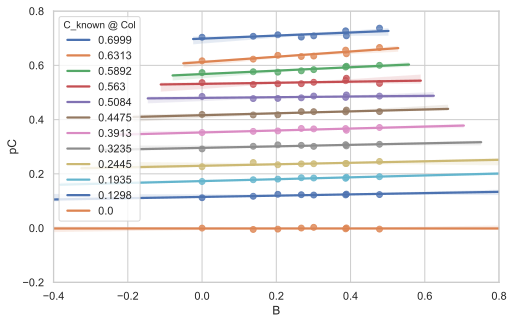

coefs [0.05652780154059861, 0.0969771552171997, 0.06316374757909168, 0.020116244387008396, 0.012551078733417827, 0.03512170590311665, 0.03607105226090205, 0.027852652326747405, 0.027497539798159068, 0.03483207277734172, 0.023395313702430393, 2.117657278345951e-05]

c_at_cols [0.6999, 0.6313, 0.5892, 0.563, 0.5084, 0.4475, 0.3913, 0.3235, 0.2445, 0.1935, 0.1298, 0.0]


In [12]:
quick_scrip()

In [13]:
# Given that the coefficients are very steady, there is likely only the dependency on the
# amount of bacteria added, therefore tak the average to model correction function

In [14]:
def quick_scrip():
    #plot_pred_vs_known(ssdf, wc)
    coefs = [0.05656595866524967, 0.06310798510369094, 0.09692445824567747,
             0.02004658756026922, 0.012604848631297547, 0.03507500526114857,
             0.03606568342979373, 0.027922980144893382, 0.02740167591277025, 
             0.034829465899238896, 0.023432031060093228, 3.5934184411490945e-07]
    # the zero is artificial as we first correct for the blank

    c_at_cols = [0.6999, 0.6313, 0.563, 0.5084, 0.5892,
                 0.4475, 0.3913, 0.3235, 0.2445, 0.1935,
                 0.1298, 0.0]

    
    print('coefs', coefs)
    print()
    print('c_at_cols', c_at_cols)
    
    fig, ax = plt.subplots(figsize=(8,5))
    
    # the coefficients have a slight dependency on the concentration of chlamy 
    # which we can exploit to correct for the values of pB
    k_fit = np.polyfit(x=c_at_cols, y=coefs, deg=1)
    k_ptor = np.poly1d(k_fit)

    xs = np.linspace(-0.05, .7, 100)
    plt.plot(c_at_cols, coefs, 'b.', xs, k_ptor(xs), 'r.', xs, np.poly1d([0, np.median(coefs)])(xs), 'k-')

    plt.xlabel('C')
    plt.ylabel('correcting_k')
    print()
    print('k_coefs_mean', np.mean(coefs[:-1]),
          'k_median', np.median(coefs[:-1]))

coefs [0.05656595866524967, 0.06310798510369094, 0.09692445824567747, 0.02004658756026922, 0.012604848631297547, 0.03507500526114857, 0.03606568342979373, 0.027922980144893382, 0.02740167591277025, 0.034829465899238896, 0.023432031060093228, 3.5934184411490945e-07]

c_at_cols [0.6999, 0.6313, 0.563, 0.5084, 0.5892, 0.4475, 0.3913, 0.3235, 0.2445, 0.1935, 0.1298, 0.0]

k_coefs_mean 0.039452425446738444 k_median 0.034829465899238896


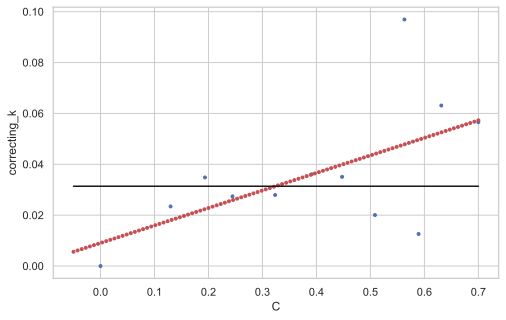

In [15]:
quick_scrip()

# It would seem that the it would probably be best to use an average or median of the ks in these
# above regressions as they seem overwhelmingly parallel, thus to make the regression above as in
# the figure below would be a stretch, use the median as it should be robust to outliers in 

In [16]:
def  corr_func_Csc(pB, pC, Ktype='median'):
    
    # obtained from the empirical data itself, regression coefficients of each
    # column's pC vs. B_known @ [C]=0 (i.e B_only well) (96-well format)
    Ks = [0.05656595866524967, 0.09692445824567747, 0.06310798510369094,
         0.02004658756026922, 0.012604848631297547, 0.03507500526114857,
         0.03606568342979373, 0.027922980144893382, 0.02740167591277025,
         0.034829465899238896, 0.023432031060093228, 3.5934184411490945e-07]
    
    
    c_at_cols = [0.6999, 0.6313, 0.563, 0.5084, 0.5892,
                 0.4475, 0.3913, 0.3235, 0.2445, 0.1935,
                 0.1298, 0.0]
    
    k_fit = np.polyfit(y=Ks, x=c_at_cols, deg=1)
    k_tor = np.poly1d(k_fit)
    
    if Ktype == 'median':
        k = np.median(Ks)
    elif Ktype== 'mean':
        k = np.mean(Ks)
    elif Ktype=='adaptive':
        k = k_tor(pC)
    
    cv_ptor = np.poly1d([k, 0])
    
    return cv_ptor(pB)

# CORRECT B

In [1]:
def quick_scrip(ylim=.8):
    
    """Here we're visualizing the predicted values of B (pB) at each well in a row by
    row basis with respect to the known concetration of C. The lines should all be
    flat if the predictions were perfect, but there is a bit of signal addition given by 
    the bacteria. The addition to the signal is dependant on the concentration of B"""
    
    fig, ax = plt.subplots(figsize=(8,5))
    b_max = []
    b_at_cols = []
    for i in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
        
        b_at_cols.append(B.loc[i][12])
        # append max value of each column
        b_max.append(max(pB.loc[i]))
        # create a regression plot for pB v [C] (C known)
        if ylim <= .2:
            
            sns.scatterplot(y=pB.loc[i], x=C.loc['H'])
            #sns.regplot(y=pB.loc[i]-pB.loc[i][12], x=C.loc['H'], order=2, truncate=False)
        else:
            sns.scatterplot(y=pB.loc[i], x=C.loc['H'])
            #sns.regplot(y=pB.loc[i], x=C.loc['H'], order=2, truncate=False)
            
        # check for any patterns --- none exist, but we do see the same


    ax.set_ylabel('pB')
    ax.set_xlabel('C')


    ax.set_ylim(-0.3, ylim)
    ax.set_xlim(-0.4, 1.4)
    ax.legend(b_at_cols, 
              title='B_known @ Row')
    plt.show()
    print('coefs', coefs)
    print('b_known_at_cols, b_max_at_col', [i for i in zip(b_at_cols, b_max)])

In [2]:
quick_scrip(ylim=1)

NameError: name 'plt' is not defined

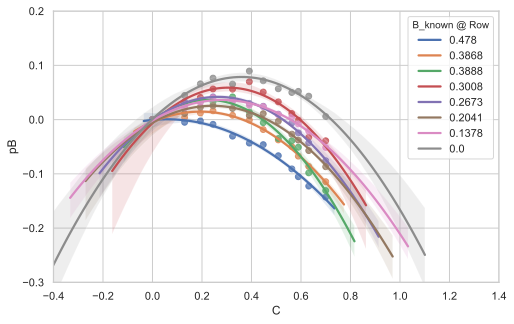

coefs 0.04256825724076642
b_known_at_cols, b_max_at_col [(0.478, 0.483985), (0.3868, 0.421214), (0.3888, 0.431038), (0.3008, 0.359926), (0.2673, 0.300049), (0.2041, 0.248695), (0.1378, 0.192354), (0.0, 0.089508)]


In [37]:
quick_scrip(ylim=.2)

# When the concentration of bacteria is Zero, the vertex (H, K) of a Parabola is found at the the midpoint
# of the concentration gradient of Chlamy (H=[C]mid, K=[B]max), as the concentration of Bacteria increases
# it shifts the Pa
#

In [38]:
# What I think is going is that there is definitely a a parabolic dependency on the amount of 
# signal added to pB from the actual concentration of [C]. At [C]=0 we know that that value is
# close to the actual amount of B in all those wells, but when actual concentration of B is low
# beer-lambert's model add C's signal to B, until a certain threshold at which point it begins to
# be distinguishable. Note also that the amount of B has the effect of shi shifting the parabola
# leftward causing the values... this indicates to me that the parabolas H,K 

In [39]:
def h_k(a2a1a0):
    a, b, c = a2a1a0
    
    h = -(b / 2*a)    
    k = a*(h**2) + b*h + c
    
    #print(2*h, k)
    
    return h, k

def quick_scrip(ylim):
    x = C.loc['H'] # pB at 96-well plate row where there should be no bacteria present
    y = pB.loc['H'] # [C] of C_only wells

    fig, ax = plt.subplots(figsize=(8,8))

    a2s = [] # a2*x**2 + a1*x + a0    
    b_max = []

    rows = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    Hs = []
    for row in rows:
        b_max.append(min(pB.loc[row]))

        y = pB.loc[row]
        pBfit = np.polyfit(x, y, deg=2)# rcond=None, full=True, w=None, cov=False)

        # We are interested in getting an average 'a2' (breadth) of the parabolas
        # alternatively we can use the 'a2' of the [B] = 0 parabola or list median
        a2s.append(pBfit[0])

        # a0 represents the y-intercept of the fitted parabola, when we truncate his
        # at 0, we essentially bring the apex of the down given that the following
        # f(x) = a2*(x-h) + k     where: h= (1/2)*(-b/a2)   and k = f(h) and h,k 
        # represents the vertex, it must be that a0 only increases the vertex's y
        # k = a2*(h)**2 + a1*x + a0
        c = pBfit[2]
        pBfit[2] = 0 
        pBtor = np.poly1d(pBfit)

        xp = np.linspace(-1, 1.5, 1000)
        plt.plot(x, y-c, '.', xp, pBtor(xp))
        
        # numerically obtain the location of x-coordinate of the vertex
        # as the analytic determinination (h_k)is not suitable
        ps=pBtor(xp).copy()
        k=max(ps)
        h=xp[np.argmax(ps)]
        Hs.append(h)
        ph,pk = h_k(pBfit)
        plt.plot(h,k, 'ro', ph, pk, 'ko')
        plt.ylim(-0.2, ylim)
        plt.xlim(-0.5, 1)
        ax.set_xlabel('C')
        ax.set_ylabel('pB')
        #plt.show()
        
    print(a2s, Hs, pBfit)
    return a2s, Hs

[0.05855855855855863, 0.1936936936936937, 0.22622622622622623, 0.3063063063063063, 0.26626626626626626, 0.24374374374374375, 0.28128128128128127, 0.3613613613613613] [-0.35858663683087716, -0.5095722051618977, -0.745803568144804, -0.6991032754990237, -0.6124032964940198, -0.5253132108936088, -0.47844649340678086, -0.5985173374093159] [-0.59851734  0.43152119  0.        ]


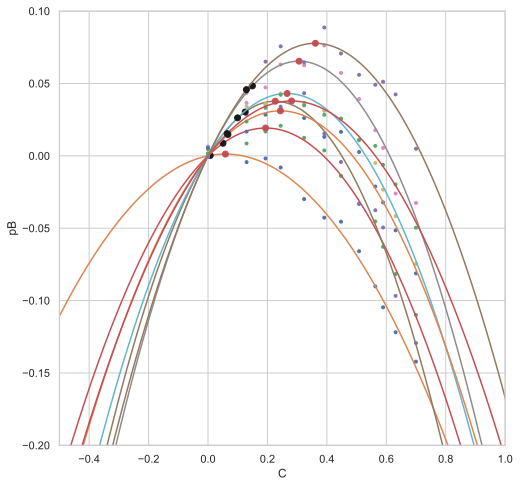

In [40]:
a2s, Hs = quick_scrip(ylim=.1)

In [41]:
def quick_scrip():

    fig, ax = plt.subplots(figsize=(9,5))

    # here were are modeling the apparent relationship that 'h' in f(h) = a(x - h)**2 + k=0 
    # pB[12] # predicted at [C] =0
    # B[12] # empirical at [C] =0
    Hs = [0.05851855851855858, 0.19423619423619432, 0.22500872500872493, 0.3058838058838058,
          0.26529126529126534, 0.24323624323624315, 0.28152128152128153, 0.36049136049136044]

    Hs = np.array(Hs)
    #Hs[0] = 0
    Hs
    b_at_c0= np.array(B[12])

    hfit = np.polyfit(b_at_c0, Hs, deg=1)
    htor = np.poly1d(hfit)
    xp = np.linspace(-0.05, .6)
    plt.plot(b_at_c0, Hs, 'ro', xp, htor(xp))
    
    ax.set_xlabel('B')
    ax.set_ylabel('H of (h,k) = C_estimated @ pBmax')
    
    plt.show()
    return htor

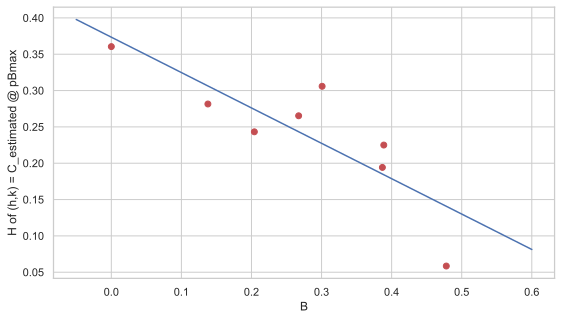

In [42]:

htor = quick_scrip()

In [43]:
# There are 3 options about which a2 to use, a2 refers to the breadth of the 
# correcting parabolas. These are either:
# the average, the median, or a2 @ [B]=0

a2_at_b0 = -0.5985173374093159 # this we know has  good fit independant of bacteria
a2_medn = np.median(a2s) # this should be more robust to outliers
a2_mean = np.mean(a2s) # this is the median

p_h = htor(pB)

#
b = -2*a2_medn*p_h
corr_func = np.poly1d(np.array([a2_medn, b, 0 ])) # use this to test things, but this block
# isn't necessary

In [44]:
def  corr_func_Bsc(pB, pC, which_a=None):
    
    # There are 3 options about which a2 to use, a2 refers to the breadth of the 
    # correcting parabolas. These are either:
    # the average, the median, or a2 @ [B]=0
    
    # a2 obtained from from the regression above from high B to B=0
    a2s = [-0.35858663683087716, -0.5095722051618977, -0.745803568144804, -0.6991032754990237,
           -0.6124032964940198, -0.5253132108936088, -0.47844649340678086, -0.5985173374093159]
    
    if which_a =='mean':
        a2 = np.mean(a2s) # this is the mean
    elif which_a =='median':
        a2 = np.median(a2s) # this should be more robust to outliers
    else:
        a2 = a2s[-1] # this we know has good fit independant of bacteria
    
    # takes in the predicted pB and spits out a likely H, one should decide whether to use
    # the predicted B values directed from the model calculations or the corrected B values
    # from the B corrections
    p_h = htor(pB)
    
    # this is from an algebraic manipulation of the parabolic function
    # in polynomial and parabolic form where h = -b/2*a2 --- since we
    # 'know' a2 and p_h is dependant on the concetration of B we 
    # estimate the likely value of b in f(x) = a2*x^2 + b*x + c
    b = -2*a2*p_h
    
    
    cv_tor = np.poly1d([a2, b, 0])
    
    return cv_tor(pC)

In [45]:
# LOGIC --- I use the fact that the predictions for Chlamy (pC) fit very well to CORRECT THE B
# signal first, then I HAVE to use the CORRECT B values to correct for C otherwise I will lose
# information... else I should should add what I subtracted... but I think we saw that din't work
# too well




#tcdf = ssdf.copy()
tcdf = scdf.copy()

tcdf['Btmp_'+wc] = tcdf['B_p'+wc].copy()
tcdf['Ctmp_'+wc] = tcdf['C_p'+wc].copy()


# CORRECT pB
# use the uncorrected values to correct these 
tcdf['cv'] =  tcdf.apply(lambda x: corr_func_Bsc(x['Btmp_'+wc], x['Ctmp_'+wc],
                         which_a='median'), axis=1)

tcdf['B_p'+wc] = tcdf['Btmp_'+wc] - tcdf['cv']

# since there is a big dependency on B already on the amount of chlamy, it doesn't make sense to
# use the uncorrected values to correct for C
tcdf['cv2'] =  tcdf.apply(lambda x: corr_func_Csc(x['B_p'+wc], x['Ctmp_'+wc],
                          Ktype='adaptive'), axis=1)
# CORRECT pC
tcdf['C_p'+wc] = tcdf['Ctmp_'+wc] - tcdf['cv2']

# in this case it does not make sense to reattribute gleaned signal to B
#tcdf['B_'+wc] = tcdf['Btmp_'+wc] - tcdf['cf']





# sample of corrections made
tcdf[['Btmp_'+wc,'B', 'cv', 'B_p'+wc,'Ctmp_'+wc,'C', 'C_p'+wc]].sample(n=10).sort_values(by='well')

,Btmp_560,B,cv,B_p560,Ctmp_560,C,C_p560
well,,,,,,,
A3,0.378696,0.4780,-0.074885,0.453581,0.600190,0.5892,0.576915
B6,0.386605,0.3868,-0.013991,0.400596,0.428547,0.4475,0.413030
C1,0.258366,0.3888,-0.085147,0.343513,0.709029,0.6999,0.688662
C10,0.423304,0.3888,0.015511,0.407792,0.187455,0.1935,0.178866
C3,0.338274,0.3888,-0.060066,0.398339,0.596661,0.5892,0.576324
D8,0.346169,0.3008,0.018369,0.327800,0.301341,0.3235,0.291700
E6,0.282771,0.2673,0.010155,0.272616,0.429468,0.4475,0.418890
F10,0.245646,0.2041,0.033191,0.212455,0.180554,0.1935,0.176186
F8,0.243366,0.2041,0.035006,0.208360,0.306985,0.3235,0.300771


array([[1.        , 0.99711904],
       [0.99711904, 1.        ]])

array([[1.       , 0.9985835],
       [0.9985835, 1.       ]])

'original'

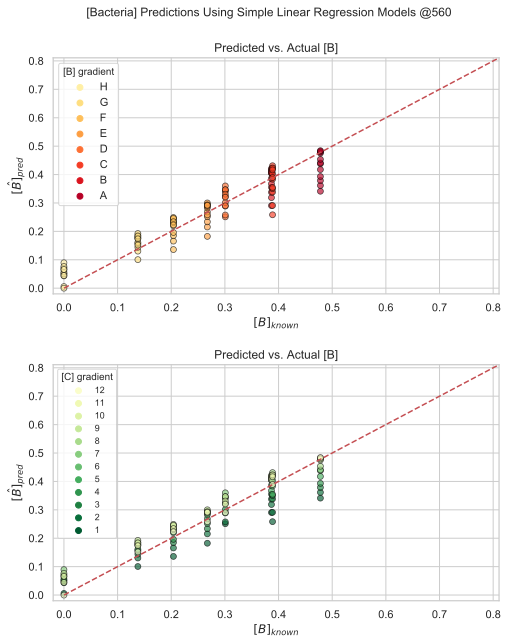

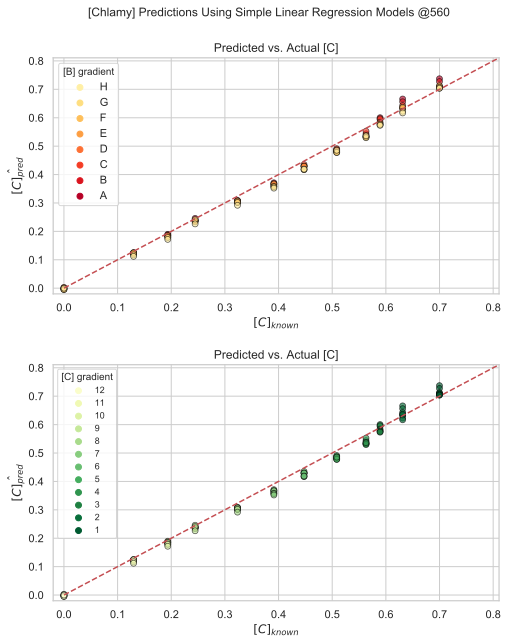

'corrected'

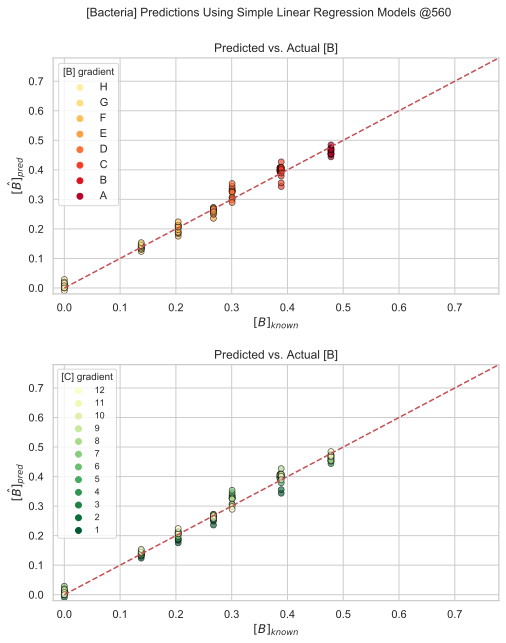

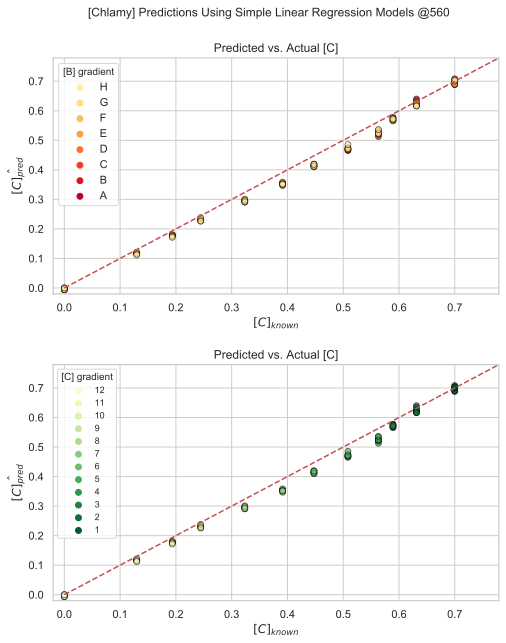

In [46]:
# corrected values
tcdf['sum'] = tcdf[['C_p560', 'B_p560']].apply(np.sum, axis=1)

# original values
tcdf['sum2'] = tcdf[['Ctmp_560', 'Btmp_560']].apply(np.sum, axis=1)

np.corrcoef(x=tcdf['560'], y=tcdf['sum'])
np.corrcoef(x=tcdf['560'], y=tcdf['sum2'])

'original'
plot_pred_vs_known(scdf, column=wc, ml_model=False)

'corrected'
plot_pred_vs_known(tcdf, column=wc, ml_model=False)

array([[1.        , 0.99711904],
       [0.99711904, 1.        ]])

<module 'numpy' from '/home/rdmtinez/program_files/anaconda3/envs/fluxy/lib/python3.7/site-packages/numpy/__init__.py'>

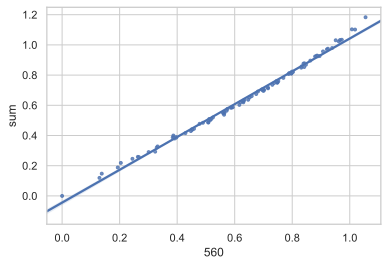

In [47]:
tcdf['sum'] = tcdf['C_p560']+ tcdf['B_p560']
tcdf['sum2'] = tcdf['Ctmp_560']+ tcdf['Btmp_560']

#sns.scatterplot(data=tcdf, x='560', y='sum')
sns.regplot(data=tcdf, x='560', y='sum', marker='.')
np.corrcoef(x=tcdf['560'], y=tcdf['sum'])

np

array([[1.       , 0.9985835],
       [0.9985835, 1.       ]])

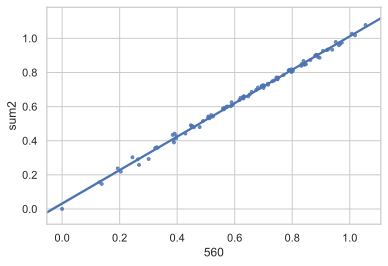

In [227]:
sns.regplot(data=tcdf, x='560', y='sum2', marker='.')
np.corrcoef(x=tcdf['560'], y=tcdf['sum2'])

In [228]:
trc = tcdf[(tcdf['B']<=0.4) & (tcdf['C']<=0.4) ].copy()

In [229]:
trc['sum'] = trc[['C_p560', 'B_p560']].apply(np.sum, axis=1)
trc['sum2'] = trc[['Ctmp_560', 'Btmp_560']].apply(np.sum, axis=1)

In [230]:
np.corrcoef(x=trc['560'], y=trc['sum'])
np.corrcoef(x=trc['560'], y=trc['sum2'])

array([[1.        , 0.99874316],
       [0.99874316, 1.        ]])

array([[1.        , 0.99719497],
       [0.99719497, 1.        ]])

In [50]:
def apply_correcting_functions(df, wc='560'):
    # LOGIC --- I use the fact that the predictions for Chlamy (pC) fit very well to CORRECT THE B
    # signal first, then I HAVE to use the CORRECT B values to correct for C otherwise I will lose
    # information... else I should should add what I subtracted... but I think we saw that din't work
    # too well




    cdf = df.copy()
    
    # creates a copy of the uncorrected values (pB and pC), this allows renaming using 
    # the plotting function without making to many changes to it
    cdf['Btmp_'+wc] = cdf['B_p'+wc].copy()
    cdf['Ctmp_'+wc] = cdf['C_p'+wc].copy()


    # CORRECT pB
    # pass the uncorrected values of both predictions to correct B
    cdf['cv'] =  cdf.apply(lambda x: corr_func_Bsc(x['Btmp_'+wc], x['Ctmp_'+wc],
                             which_a='median'), axis=1)

    cdf['B_p'+wc] = cdf['Btmp_'+wc] - cdf['cv']

    # CORRECT pC
    # pass the uncorrected values of C pC and the corrected values of B (cPc), since we
    # are working on the idea that the Chlamy predictions are close to ground truth we
    # first correct B with those C values, and then get the B values as close to their
    # respective ground truth to correct C
    cdf['cv2'] =  cdf.apply(lambda x: corr_func_Csc(x['B_p'+wc], x['Ctmp_'+wc],
                              Ktype='adaptive'), axis=1)
    cdf['C_p'+wc] = cdf['Ctmp_'+wc] - cdf['cv2']


    
    return cdf

# Validation
    
### Method 1

    # to use Calibratioin 1 data as validation----
    # the problem with this is that the data collected was very noisy, and its not at all
    # clear whether it was experiemental error or if the tecan itself was affected, thus
    # there can be random variability in our measurements that cannot be corrected
    
    # search for instrument failure in research , random error vs exp. error vs. other kinds of errso, what can be corrected for and what cannot be

    # two methods:
        1. apply SynCom correction functions to pB, pC in current dataframe even though the predictions were made using models derived from its own data (i.e. those models aren't that good at having consistent prediction)
        
        2. apply SynCom a680_a720 ~ a560 models to Cal1 Data, then apply correction function

In [51]:

# Method 1 was a failure --- I already half-heartedly expected that

In [52]:
# single strain with predicitons
#c_ssdf = apply_correcting_functions(df=ssdf, wc='560')

In [53]:
#plot_pred_vs_known(c_ssdf, column='560', ml_model=False)

# the plot does not show any good results

### Method 2

In [57]:
# apply SC models to SS data and predict 560 'concentrations' [x]
path = '/home/rdmtinez/Documents/B-IT MS Program/Masters Thesis/data_o/\
calibration/validation'

# load validation data
validata = pd.read_csv(pjoin(path,'sc_models_on_ss_data_pred_560_a680_a720.csv'),
                      index_col='well')
validata.head()

,row,col,B_lbl,C_lbl,F680,A680,A750,320,325,330,...,765,770,775,780,785,790,795,800,B_p560,C_p560
well,,,,,,,,,,,,,,,,,,,,,
A1,A,1,0.200,0.25,4666.0,0.7210,0.4146,0.8399,0.8359,0.8349,...,0.4095,0.4067,0.4043,0.4019,0.3995,0.3977,0.3955,0.3937,0.230315,0.322719
B1,B,1,0.175,0.25,4832.0,0.7822,0.4155,0.8916,0.8890,0.8907,...,0.4099,0.4070,0.4041,0.4014,0.3989,0.3967,0.3943,0.3923,0.158287,0.396723
C1,C,1,0.150,0.25,4638.0,0.6925,0.3829,0.7923,0.7897,0.7912,...,0.3741,0.3710,0.3688,0.3665,0.3642,0.3622,0.3600,0.3582,0.173351,0.334322
D1,D,1,0.125,0.25,4775.0,0.6981,0.3593,0.7690,0.7657,0.7669,...,0.3418,0.3389,0.3366,0.3342,0.3319,0.3299,0.3277,0.3258,0.077361,0.386595
E1,E,1,0.100,0.25,4936.0,0.6788,0.3414,0.7440,0.7413,0.7438,...,0.3266,0.3236,0.3214,0.3191,0.3168,0.3146,0.3124,0.3105,0.061885,0.382696


In [58]:
c_validata = apply_correcting_functions(df=validata, wc='560')

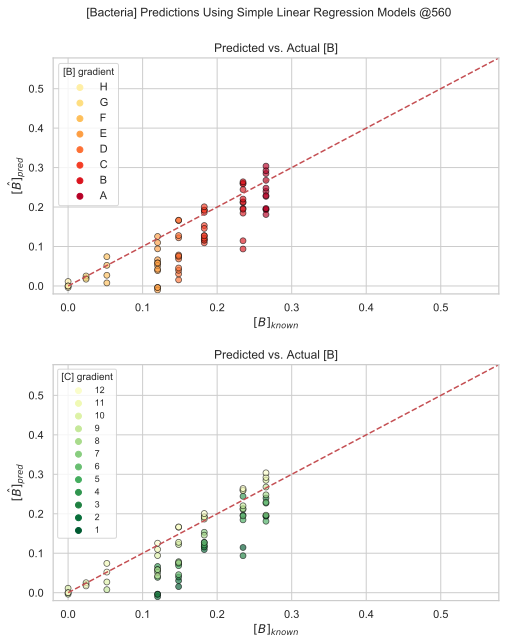

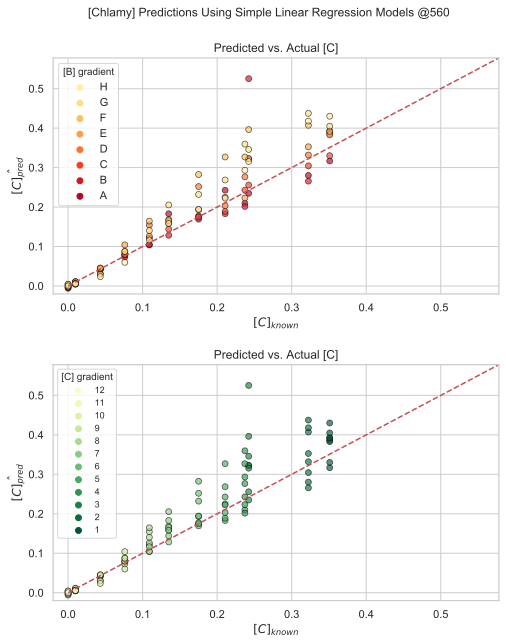

In [59]:
plot_pred_vs_known(c_validata, column='560', ml_model=False)

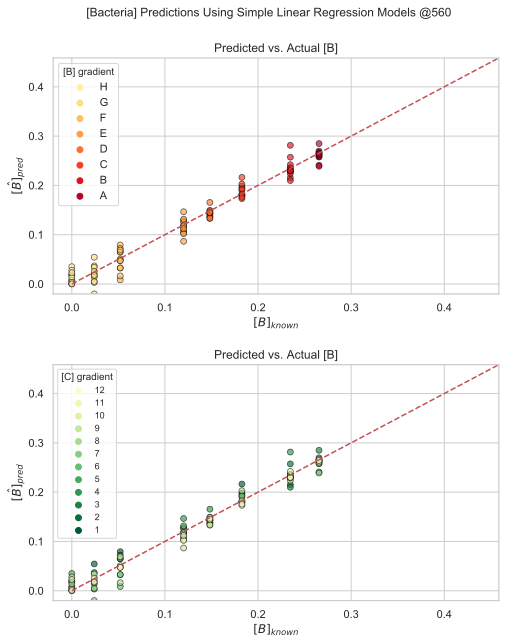

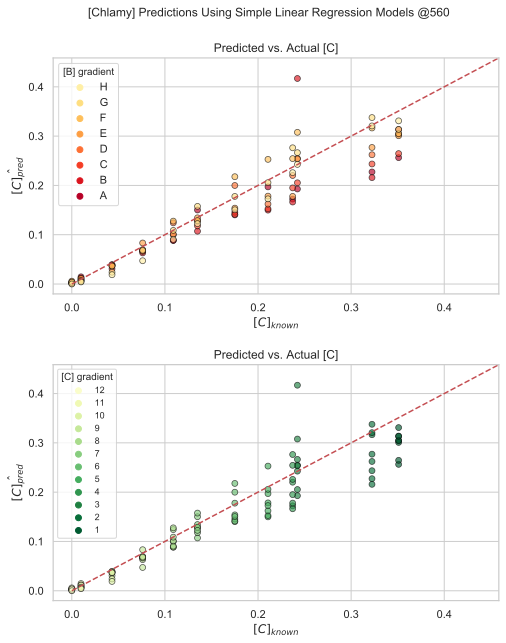

In [60]:
plot_pred_vs_known(ssdf, column='560', ml_model=False)

In [282]:
# How similar are the models themselves

#sc_model
#560	0.834127837	1.638846922	0.773945696	0.826255292	-1.472662044	3.136375574	1.353036608	-1.49506327

# ss_model
#560	0.921885444	1.863641627	0.870440283	0.839434975	-0.974654273	2.137588775	0.920606905	-0.831220282

# How similar are the predictions at [B \\ C]-only wells
pd.concat([ssdf[(ssdf['B']==0) | (ssdf['C']==0)][['B', 'C']],scdf[(scdf['B']==0) | (scdf['C']==0)][['B', 'C']]], axis=1)

/home/rdmtinez/program_files/anaconda3/envs/fluxy/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


,B,C,B,C
A12,0.2655,0.0000,0.4780,0.0000
B12,0.2347,0.0000,0.3868,0.0000
C12,0.1827,0.0000,0.3888,0.0000
D12,0.1483,0.0000,0.3008,0.0000
E12,0.1201,0.0000,0.2673,0.0000
F12,0.0520,0.0000,0.2041,0.0000
G12,0.0241,0.0000,0.1378,0.0000
H1,0.0000,0.3510,0.0000,0.6999
H10,0.0000,0.0432,0.0000,0.1935
H11,0.0000,0.0099,0.0000,0.1298


In [ ]:
# conclusion about the ss_data as a validation set is that 
# you cannot use the SynComm models to model sing-strain data
# even though we think that the bacteria measurements for either
# ss or sc are fundamentaly the same, we really don't know what
# other factors can be are at play, e.g. are there elements in
# bacteria species that absorb differently.... we also cannot 
# assert that the tecan was problem-free during the time 
# that the screening data was taken, nor the first calibration

# speakin of:
    #what's absorbtion look at for ss_data,
    #the else can be inside these

# we note that sing strain models has its own correction facter
# and that we can correct these models
# thus given that we expect, we